In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

from torch.nn.modules.utils import _pair, _quadruple

print(torch.__version__)
device = torch.device('cuda:0')

1.2.0


In [2]:
class Flatness_Pool2d(nn.Module):
    """ 
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False, mode="constant", alpha=0):
        super(Flatness_Pool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same
        self.mode = mode
        self.alpha = alpha

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def flatness(self, x):
        epsilon = 10e-4
        x = F.relu(x) + epsilon
        n = x.size(-1)
        arithmetic_mean = x.mean(dim=-1)
        #geometric_mean = x.prod(dim=-1)
        #geometric_mean = geometric_mean.pow(1./n)
        ln_x = torch.log(x)
        geometric_mean = ln_x.mean(dim=-1)
        geometric_mean = torch.exp(geometric_mean)
        return geometric_mean/arithmetic_mean

    def f(self, flatness, alpha):
        return 2*alpha*flatness + (1-alpha)
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode=self.mode)
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,))
        max_pool = x.max(dim = -1)[0]
        flatness = self.flatness(x)
        #c = self.f(flatness, self.alpha)
        #out = torch.pow(max_pool, c)
        return flatness

In [3]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        classes = self.target_labels[idx][1]
        family =  self.target_labels[idx][0]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes, family
    
class calTech(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('features')) / 255.0
        self.input_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        return images, labels

In [4]:
INPUT_CHANNEL = 3
BATCH_SIZE = 32
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

classes = [str(i) for i in range(102)]

data_path = os.path.dirname(os.getcwd()) + "/data/calTech/"
Train_data = calTech(data_path + "train.h5", transform=normalize)
Train_dataloader = DataLoader(dataset=Train_data, batch_size = BATCH_SIZE, shuffle=True)

print(Train_data.__len__())
def get_iterator(mode):
    if mode is True:
        return Train_dataloader
    elif mode is False:
        return Train_dataloader

9145


In [5]:
class CorssEntropyloss(nn.Module):
    def __init__(self):
        super(CorssEntropyloss, self).__init__()
        self.class_loss = nn.CrossEntropyLoss()
       
    def forward(self, predicted_class, true_class):
        return self.class_loss(predicted_class, true_class)

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class My_Model(nn.Module):
    def __init__(self, input_channel=3, num_class=21, alpha=0):
        super(My_Model, self).__init__()
        self.model_ft = models.resnet18(pretrained=True)
        set_parameter_requires_grad(self.model_ft, False)
        
        #modified pooling
        self.model_ft.avgpool = Flatness_Pool2d(kernel_size=7, stride=1, alpha=alpha)
        
        #change FC
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.model_ft(x)
        return x

In [7]:
from torchsummary import summary
train_images, _, = next(iter(Train_dataloader))

_model = My_Model(num_class = 102, alpha=0)
summary(_model, input_size= train_images[0].size(), device="cpu")
_model = _model.to(device)
#print(_model)
#_loss = LabelSmoothingLoss(classes = 21, smoothing = 0.1)
_loss = CorssEntropyloss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [8]:
def main():
    #main processor
    def h(sample):
        data, classes, training = sample
        
        if(training):
            _model.train()
        else:
            _model.eval()
        labels = torch.LongTensor(classes).to(device)
        data = data.to(device).float()
        
        f_class = _model(data)
        loss = _loss(f_class, labels)
        
        p_class = F.softmax(f_class, dim=1)
        return loss, p_class
    
    #---------log--------------
    def plot_log(log):
        log = np.array(log)
        fig = plt.figure(figsize = (15, 8))
        #loss
        plt.plot(log[:,0]); plt.plot(log[:,2])
        plt.title("Loss per epoch"); plt.xlabel("epochs"); plt.ylabel("error")
        plt.legend(["training loss", "validation loss"])
        plt.show()
        fig = plt.figure(figsize = (15, 8))
        #accuracy
        max_value = np.round(np.max(log[:, 3]), decimals=4)
        max_index = np.argmax(log[:, 3])
        plt.plot(log[:,1]); plt.plot(log[:,3])
        plt.text(max_index, max_value, str(max_value), fontsize=10)
        plt.title("Accuracy per epoch"); plt.xlabel("epochs"); plt.ylabel("ACC")
        plt.legend(["training accuracy", "validation accuracy"])
        plt.show()
        
    log = []
    engine = Engine()
    EPOCHS = 100
    optimizer = torch.optim.Adam(_model.parameters(), lr=0.001)
    meter_loss = tnt.meter.AverageValueMeter()
    classerr = tnt.meter.ClassErrorMeter(accuracy=True)
    
    def reset_meters():
        classerr.reset()
        meter_loss.reset()

    def on_sample(state):
        state['sample'].append(state['train'])

    def on_forward(state):
        classerr.add(state['output'].data, torch.LongTensor(state['sample'][1]))
        meter_loss.add(state['loss'].item())

    def on_start_epoch(state):
        reset_meters()
        state['iterator'] = tqdm(state['iterator'], desc="[Epoch %d / %d]"%(state['epoch'] + 1, EPOCHS))

    def on_end_epoch(state):
        log.append([])
        display.clear_output(wait=True)
        print('Training loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        # do validation at the end of each epoch
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        reset_meters()
        engine.test(h, get_iterator(False))
        print('Testing loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        if(classerr.value()[-1] == np.max(np.array(log)[:, 3])):
            torch.save(_model.state_dict(), 'epochs/ResNet-flatness-only-CalTech.pt')
        
        plot_log(log)
        plt.pause(0.005)
        
    engine.hooks['on_sample'] = on_sample
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch
    engine.train(h, get_iterator(True), maxepoch=EPOCHS, optimizer=optimizer)

Training loss: 0.0178, accuracy: 99.5298%
Testing loss: 0.0118, accuracy: 99.6501%


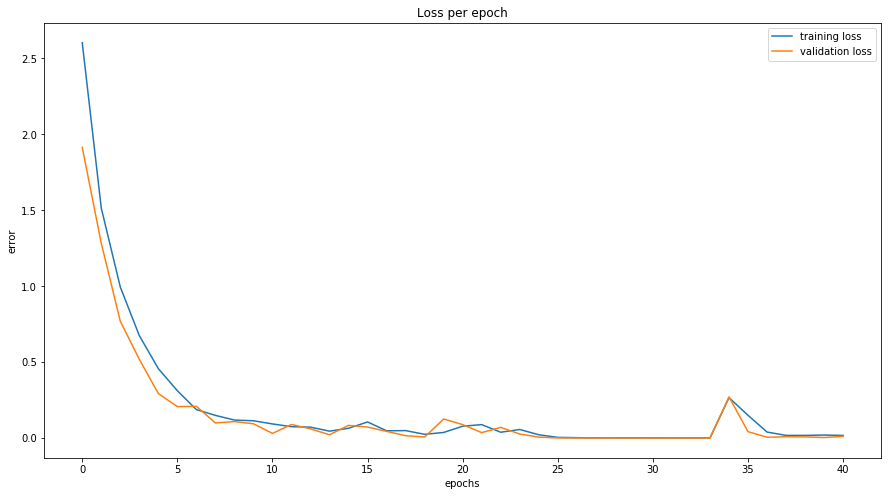

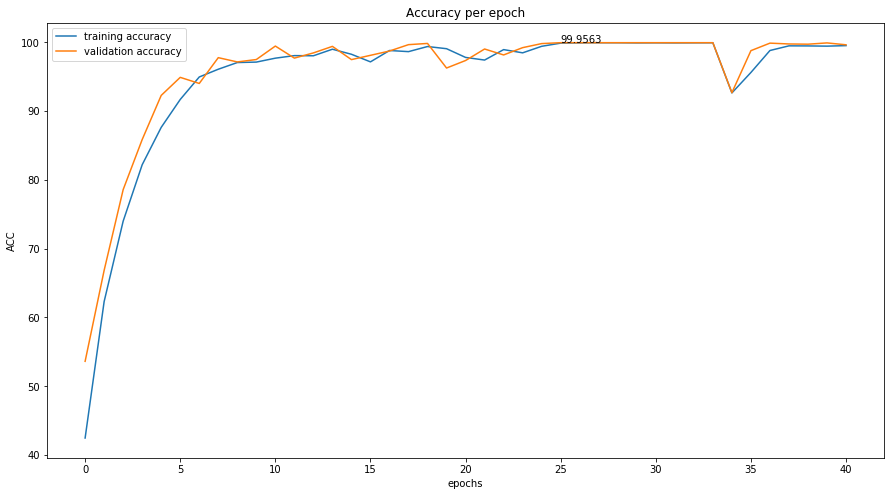

KeyboardInterrupt: 

In [9]:
main()